In [6]:
import os
import sys
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from matplotlib import pyplot as plt
sns.set_style("whitegrid")
%matplotlib inline

import datetime
from datetime import date
from collections import namedtuple
import datetimerange
from datetimerange import DateTimeRange

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error

import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, Embedding, Dropout
from keras.optimizers import RMSprop
from keras import backend as K

import warnings
warnings.filterwarnings("ignore")

print(tf.__version__)
print(keras.__version__)

In [ ]:
from tensorflow.python.client import device_lib

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0, 1"

print("GPU in use:", tf.test.is_gpu_available())
device_lib.list_local_devices()

In [7]:
train = pd.read_csv('./dataset/observations_train.csv')

In [8]:
train.head()

,series_id,date,value
0,AAA10Y,2000-01-03 00:00:00.0000000,1.17
1,AAA10Y,2000-01-04 00:00:00.0000000,1.20
2,AAA10Y,2000-01-05 00:00:00.0000000,1.16
3,AAA10Y,2000-01-06 00:00:00.0000000,1.15
4,AAA10Y,2000-01-07 00:00:00.0000000,1.17


In [9]:
test = pd.read_csv('./dataset/observations_test.csv')

In [10]:
test.head()

,series_id,date,value
0,AAA10Y,2018-01-02 00:00:00.0000000,1.06
1,AAA10Y,2018-01-03 00:00:00.0000000,1.06
2,AAA10Y,2018-01-04 00:00:00.0000000,1.01
3,AAA10Y,2018-01-05 00:00:00.0000000,1.03
4,AAA10Y,2018-01-08 00:00:00.0000000,1.01


In [11]:
series = pd.read_csv('./dataset/series.csv')

In [12]:
daily = series[series['frequency']=='Daily']['series_id']

In [13]:
train.dtypes

series_id     object
date          object
value        float64
dtype: object

In [35]:
# timestamp convert to datetime
train['date_t']=pd.to_datetime(train['date']).apply(lambda x: datetime.datetime(x.date().year, x.date().month, x.date().day))
test['date_t']=pd.to_datetime(test['date']).apply(lambda x: datetime.datetime(x.date().year, x.date().month, x.date().day))

In [15]:
train.head()

,series_id,date,value,date_t
0,AAA10Y,2000-01-03 00:00:00.0000000,1.17,2000-01-03
1,AAA10Y,2000-01-04 00:00:00.0000000,1.20,2000-01-04
2,AAA10Y,2000-01-05 00:00:00.0000000,1.16,2000-01-05
3,AAA10Y,2000-01-06 00:00:00.0000000,1.15,2000-01-06
4,AAA10Y,2000-01-07 00:00:00.0000000,1.17,2000-01-07


In [16]:
def find_overlap_date(range1, range2):
    '''
    Calculate the overlapped time range between two ranges.
    
    range1: pd.Series, dtype=str
    range2: pd.Series, dtype=str
    return: DateTimeRange
    '''
    if type(range1)!=datetimerange.DateTimeRange:
        range1 = DateTimeRange(range1.iloc[0], range1.iloc[-1])
    if type(range2)!=datetimerange.DateTimeRange:    
        range2 = DateTimeRange(range2.iloc[0], range2.iloc[-1])
    return range1.intersection(range2)

def get_overlap(dataset, daily, sp500_range):
    '''
    get overlapped time range between sp500 and all other daily-measured series.
    
    daily: daily-measured series id set
    sp500_range: pd.series
    return: time_range
            ignored series(no overlap with sp500)
    
    '''
    overlap = sp500_range
    ignore=set()
    for series in daily:
        if series=='SP500':
            continue
        # there are series with no data!
        if len(train[train['series_id']==series])==0:
            ignore.add(series)
            continue

        range2=dataset[dataset['series_id']==series]['date']
        temp = find_overlap_date(overlap, range2)
#         print(temp)
        if str(temp)=='NaT - NaT':
            ignore.add(series)
        else:
            overlap = temp
            
            
    overlap.start_time_format = "%Y-%m-%d"
    overlap.end_time_format = "%Y-%m-%d"
    
    return overlap, ignore

In [17]:
sp=train[train['series_id']=='SP500']
overlap, ignore = get_overlap(train, daily, sp['date'])

In [20]:
sp500_train = sp[sp['date_t'].isin(overlap.range(datetime.timedelta(days=1)))][['value', 'date_t']]

In [51]:
def create_timeseries(train=train, test=test):
    sp_train = train[train['series_id']=='SP500']
    sp_test = test[test['series_id']=='SP500']
    overlap_train, ignore_train = get_overlap(train, daily, sp_train['date'])
    overlap_test, ignore_test = get_overlap(test, daily, sp_test['date'])
    
    training = sp_train[sp_train['date_t'].isin(overlap_train.range(datetime.timedelta(days=1)))][['value', 'date_t']]
    training = training.set_index("date_t").rename(columns={"value": "SP500"})
    testing = sp_test[sp_test['date_t'].isin(overlap_test.range(datetime.timedelta(days=1)))][['value', 'date_t']]
    testing = testing.set_index("date_t").rename(columns={"value": "SP500"})
    
    for m_index in daily:
        if m_index in ignore:
            continue
        index_train = train[train['series_id']==m_index]
        index_train_series = index_train[index_train['date_t'].isin(overlap_train.range(datetime.timedelta(days=1)))]['value']
        index_test = test[test['series_id']==m_index]
        index_test_series = index_test[index_test['date_t'].isin(overlap_test.range(datetime.timedelta(days=1)))]['value']
        training[m_index] = index_train_series.values
        testing[m_index] = index_test_series.values
    
    return training, testing
    

In [53]:
tr, te = create_timeseries()
tr.to_csv("./dataset/train.csv")
te.to_csv("./dataset/test.csv")

In [63]:
tr.head()

,SP500,AAA10Y,BAA10Y,DEXCHUS,DEXUSEU,DEXUSUK,DFII10,DFII20,DFII30,DFII5,DFII7,DLTIIT,DPCREDIT,DPRIME,EFFR,EFFRVOL,OBFR,OBFRVOL,T10YIE,TEDRATE
date_t,,,,,,,,,,,,,,,,,,,,
2016-03-01,1978.35,2.08,3.54,6.5500,1.0847,1.3948,0.35,0.75,1.04,0.02,0.18,0.86,1.0,3.5,0.36,76.0,0.37,324.0,1.48,0.30
2016-03-02,1986.45,2.06,3.50,6.5499,1.0845,1.4059,0.33,0.73,1.00,0.00,0.16,0.83,1.0,3.5,0.37,75.0,0.37,333.0,1.51,0.28
2016-03-03,1993.40,2.06,3.47,6.5312,1.0948,1.4152,0.30,0.70,0.97,-0.03,0.12,0.80,1.0,3.5,0.37,75.0,0.37,326.0,1.53,0.37
2016-03-04,1999.99,2.04,3.43,6.5064,1.1010,1.4226,0.37,0.76,1.02,0.02,0.19,0.85,1.0,3.5,0.36,75.0,0.37,325.0,1.51,0.35
2016-03-07,2001.76,2.00,3.39,6.5155,1.1004,1.4256,0.43,0.81,1.06,0.06,0.25,0.89,1.0,3.5,0.36,72.0,0.37,320.0,1.48,0.32


Text(0.5, 1.0, 'Training SP500')

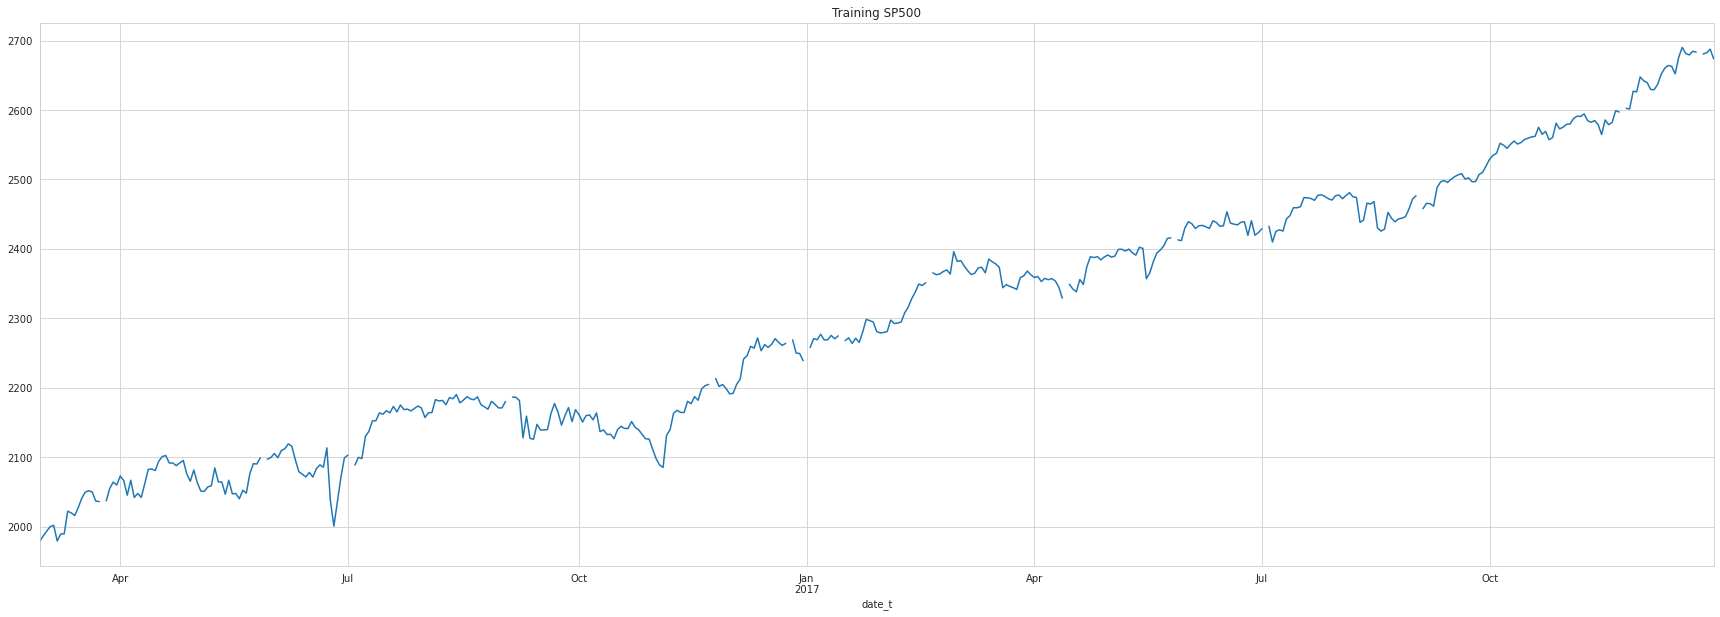

In [59]:
def plot_data(df, col, start, end, size=(30, 10)):
    df[col][start:end].plot(figsize=size)

plot_data(tr, "SP500", "2016-03-01", "2017-12-29")
plt.title("Training SP500")

Text(0.5, 1.0, 'Testing SP500')

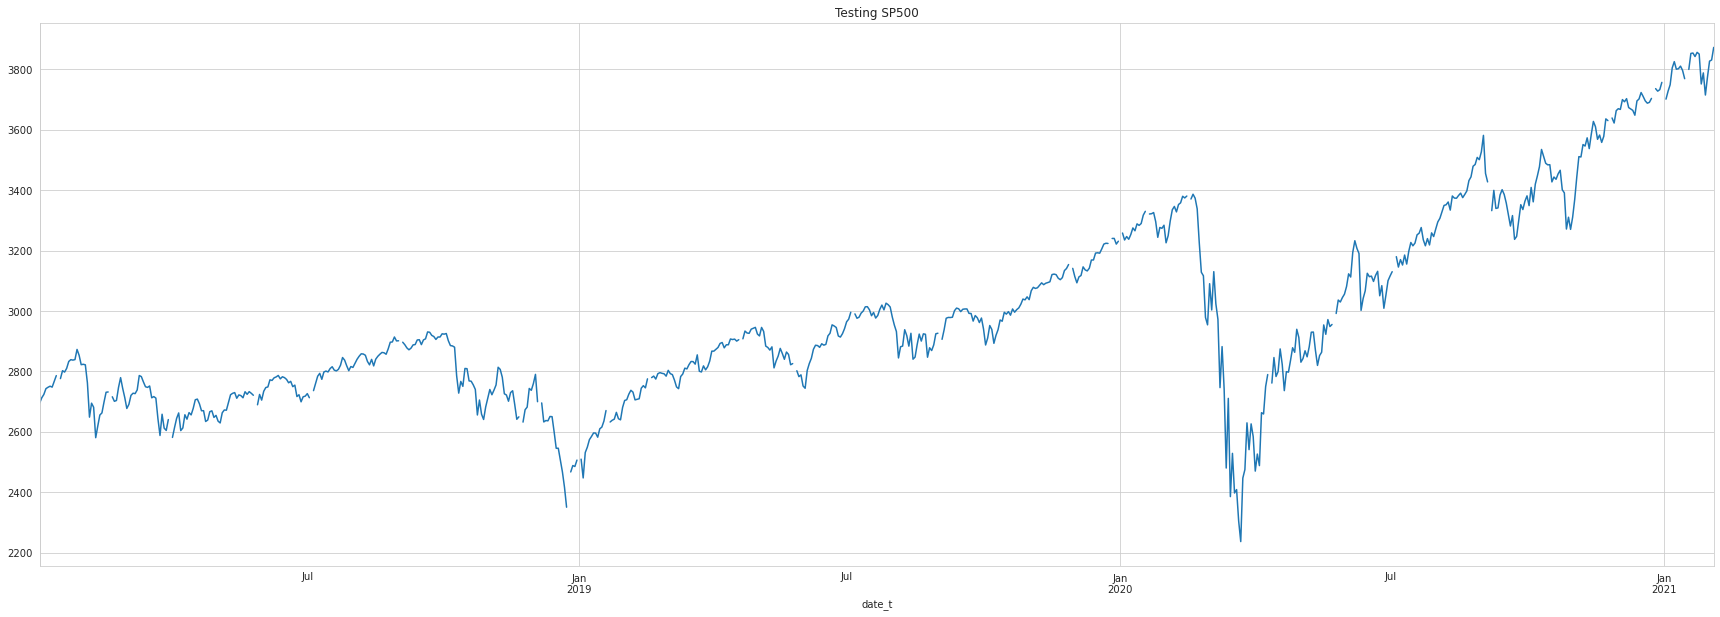

In [62]:
plot_data(te, "SP500", "2018-01-02", "2021-02-04")
plt.title("Testing SP500")

## Preprocessing

In [64]:
# Imputing
print(pd.isnull(tr).sum())
print(pd.isnull(te).sum())

SP500       15
AAA10Y      19
BAA10Y      19
DEXCHUS     18
DEXUSEU     18
DEXUSUK     18
DFII10      18
DFII20      18
DFII30      18
DFII5       18
DFII7       18
DLTIIT      18
DPCREDIT     0
DPRIME      15
EFFR        16
EFFRVOL     16
OBFR        16
OBFRVOL     16
T10YIE      18
TEDRATE     26
dtype: int64
SP500       29
AAA10Y      35
BAA10Y      35
DEXCHUS     38
DEXUSEU     38
DEXUSUK     38
DFII10      35
DFII20      35
DFII30      35
DFII5       35
DFII7       35
DLTIIT      35
DPCREDIT     0
DPRIME      28
EFFR        30
EFFRVOL     30
OBFR        30
OBFRVOL     30
T10YIE      35
TEDRATE     48
dtype: int64


In [71]:
# mean imputation
for null_index in pd.isnull(tr).sum().index:
    if pd.isnull(tr).sum()[null_index] != 0:
        tr[null_index] = tr[null_index].fillna(np.mean(tr[null_index]))

for null_index in pd.isnull(te).sum().index:
    if pd.isnull(te).sum()[null_index] != 0:
        te[null_index] = te[null_index].fillna(np.mean(te[null_index]))

print(pd.isnull(tr).sum()) 
print(pd.isnull(te).sum()) 

SP500       0
AAA10Y      0
BAA10Y      0
DEXCHUS     0
DEXUSEU     0
DEXUSUK     0
DFII10      0
DFII20      0
DFII30      0
DFII5       0
DFII7       0
DLTIIT      0
DPCREDIT    0
DPRIME      0
EFFR        0
EFFRVOL     0
OBFR        0
OBFRVOL     0
T10YIE      0
TEDRATE     0
dtype: int64
SP500       0
AAA10Y      0
BAA10Y      0
DEXCHUS     0
DEXUSEU     0
DEXUSUK     0
DFII10      0
DFII20      0
DFII30      0
DFII5       0
DFII7       0
DLTIIT      0
DPCREDIT    0
DPRIME      0
EFFR        0
EFFRVOL     0
OBFR        0
OBFRVOL     0
T10YIE      0
TEDRATE     0
dtype: int64


In [73]:
# Standardization
def scale_data(data, column, feature_range=(0, 1)):
    #scaler = MinMaxScaler(feature_range=feature_range)
    scaler = StandardScaler()
    col = np.array(data[column]).reshape(-1, 1)
    return scaler.fit_transform(col)


for col in tr.columns:
    tr[col] = scale_data(tr, col)
    
for col in te.columns:
    te[col] = scale_data(te, col)

In [105]:
tr.head(10)

,SP500,AAA10Y,BAA10Y,DEXCHUS,DEXUSEU,DEXUSUK,DFII10,DFII20,DFII30,DFII5,DFII7,DLTIIT,DPCREDIT,DPRIME,EFFR,EFFRVOL,OBFR,OBFRVOL,T10YIE,TEDRATE
date_t,,,,,,,,,,,,,,,,,,,,
2016-03-01,-1.779717,2.259467,3.039722,-1.137862,-0.851237,1.227402,0.028828,0.528594,1.326907,0.005369,-0.092957,1.096249,-0.991749,-1.009016,-1.090058,-0.078230,-1.061787,2.493713,-1.499291,-0.787925
2016-03-02,-1.735146,2.168685,2.932223,-1.138574,-0.856013,1.393893,-0.089829,0.379826,1.021284,-0.089825,-0.187036,0.868159,-0.991749,-1.009016,-1.060359,-0.165509,-1.061787,2.709117,-1.333582,-0.978950
2016-03-03,-1.696903,2.168685,2.851598,-1.271716,-0.610040,1.533386,-0.267814,0.156674,0.792067,-0.232615,-0.375195,0.640069,-0.991749,-1.009016,-1.060359,-0.165509,-1.061787,2.541580,-1.223109,-0.119338
2016-03-04,-1.660642,2.077904,2.744099,-1.448290,-0.461979,1.644380,0.147484,0.602978,1.174095,0.005369,-0.045917,1.020219,-0.991749,-1.009016,-1.090058,-0.165509,-1.061787,2.517647,-1.333582,-0.310363
2016-03-07,-1.650902,1.896342,2.636599,-1.383499,-0.476307,1.689378,0.503455,0.974898,1.479718,0.195756,0.236321,1.324338,-0.991749,-1.009016,-1.090058,-0.427345,-1.061787,2.397978,-1.499291,-0.596900
2016-03-08,-1.774709,1.987123,2.609724,-1.462530,-0.418993,1.642880,0.147484,0.528594,1.097690,-0.042228,-0.045917,0.944189,-0.991749,-1.009016,-1.090058,-0.427345,-1.061787,2.565514,-1.609764,-0.310363
2016-03-09,-1.719684,1.850951,2.555975,-1.419098,-0.433322,1.659379,0.266141,0.826130,1.403312,0.005369,0.048162,1.172278,-0.991749,-1.009016,-1.090058,-0.165509,-1.061787,2.445845,-1.333582,-0.501388
2016-03-10,-1.717978,1.669388,2.394725,-1.444018,-0.098989,1.764373,0.622111,1.049282,1.479718,0.386144,0.377440,1.400368,-0.991749,-1.009016,-1.090058,-0.427345,-1.061787,2.661249,-1.499291,-0.596900
2016-03-11,-1.538485,1.351654,2.287226,-1.536577,-0.056004,1.944364,0.562783,1.123666,1.708935,0.290950,0.330400,1.552428,-0.991749,-1.009016,-1.090058,-0.776459,-1.061787,2.254375,-1.167873,-0.692412


In [115]:
# Data Creation and Timesteps
TIMESTEPS = 7  # number of days

def input_output(data, timesteps=TIMESTEPS):
    dim0 = data.shape[0] - timesteps
    dim1 = data.shape[1]
    X = np.zeros((dim0, timesteps, dim1))
    y = np.zeros((dim0,))
    
    for i in range(dim0):
        X[i] = data.iloc[i:timesteps+i, :]
        y[i] = data.iloc[timesteps+i, 0]
        
    return X, y

X_train, y_train = input_output(tr)
X_test, y_test = input_output(te)
print(X_train.shape)
print(y_train.shape)

(472, 7, 20)
(472,)


In [108]:
'''
TIMESTEPS = 7  # number of days

def create_data(train, test, timesteps=TIMESTEPS):
    if train.shape[0] % timesteps != 0:
        trim = int(train.shape[0] % timesteps)
        X_train = train.iloc[:-1*trim].to_numpy().reshape((train.shape[0]-trim)//timesteps, timesteps, train.shape[1])
    else:
        X_train = train.to_numpy().reshape(df.shape[0]//timesteps, timesteps, train.shape[1])
    if test.shape[0] % timesteps != 0:
        trim = int(test.shape[0] % timesteps)
        X_test = test.iloc[:-1*trim].to_numpy().reshape((test.shape[0]-trim)//timesteps, timesteps, train.shape[1])
    else:
        X_test = train.to_numpy().reshape(df.shape[0]//timesteps, timesteps, train.shape[1])

    y_train = train["SP500"].shift(1)
    y_test = test["SP500"].shift(1)
    return X_train, y_train, X_test, y_test

    
X_train, y_train, X_test, y_test = create_data(tr, te)
print(X_train.shape)
print(y_train.shape)
X_train
'''

'\nTIMESTEPS = 7  # number of days\n\ndef create_data(train, test, timesteps=TIMESTEPS):\n    if train.shape[0] % timesteps != 0:\n        trim = int(train.shape[0] % timesteps)\n        X_train = train.iloc[:-1*trim].to_numpy().reshape((train.shape[0]-trim)//timesteps, timesteps, train.shape[1])\n    else:\n        X_train = train.to_numpy().reshape(df.shape[0]//timesteps, timesteps, train.shape[1])\n    if test.shape[0] % timesteps != 0:\n        trim = int(test.shape[0] % timesteps)\n        X_test = test.iloc[:-1*trim].to_numpy().reshape((test.shape[0]-trim)//timesteps, timesteps, train.shape[1])\n    else:\n        X_test = train.to_numpy().reshape(df.shape[0]//timesteps, timesteps, train.shape[1])\n\n    y_train = train["SP500"].shift(1)\n    y_test = test["SP500"].shift(1)\n    return X_train, y_train, X_test, y_test\n\n    \nX_train, y_train, X_test, y_test = create_data(tr, te)\nprint(X_train.shape)\nprint(y_train.shape)\nX_train\n'

## Time-Series Sequence Model

In [121]:
lstm = Sequential()
lstm.add(LSTM(100, activation="relu", return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
lstm.add(Dropout(0.3))
lstm.add(LSTM(50, dropout=0.2, activation="relu", return_sequences=True))
lstm.add(Dropout(0.1))
lstm.add(LSTM(25, activation="relu"))
lstm.add(Dense(20, activation="relu"))
lstm.add(Dense(10, activation="relu"))
lstm.add(Dense(1))

lstm.compile(loss="mse", optimizer="adam", metrics=["mae", "mse"])
lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 7, 100)            48400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 7, 100)            0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 7, 50)             30200     
_________________________________________________________________
dropout_4 (Dropout)          (None, 7, 50)             0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 25)                7600      
_________________________________________________________________
dense_10 (Dense)             (None, 20)                520       
_________________________________________________________________
dense_11 (Dense)             (None, 10)                210       
__________

In [122]:
EPOCHS = 20
BATCH_SIZE = 64

history = lstm.fit(X_train, 
                   y_train,
                   epochs=EPOCHS,
                   batch_size=BATCH_SIZE,
                   verbose=1,
                   shuffle=False)

Epoch 1/20
472/472 [==============================] - 4s 8ms/step - loss: 0.9880 - mean_absolute_error: 0.8597 - mean_squared_error: 0.9880
Epoch 2/20
472/472 [==============================] - 0s 826us/step - loss: 0.9338 - mean_absolute_error: 0.8377 - mean_squared_error: 0.9338
Epoch 3/20
472/472 [==============================] - 0s 833us/step - loss: 0.8053 - mean_absolute_error: 0.7848 - mean_squared_error: 0.8053
Epoch 4/20
472/472 [==============================] - 0s 940us/step - loss: 0.5431 - mean_absolute_error: 0.5864 - mean_squared_error: 0.5431
Epoch 5/20
472/472 [==============================] - 0s 954us/step - loss: 0.5931 - mean_absolute_error: 0.6538 - mean_squared_error: 0.5931
Epoch 6/20
472/472 [==============================] - 0s 897us/step - loss: 0.4983 - mean_absolute_error: 0.5603 - mean_squared_error: 0.4983
Epoch 7/20
472/472 [==============================] - 0s 1ms/step - loss: 0.6223 - mean_absolute_error: 0.6396 - mean_squared_error: 0.6223
Epoch 8/20